In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from utils import data_preprocessing_util as dpu
from utils import classification_util as cu
from utils import ex2_helper as helper

from MLP import MLP
from nn_framework import NNFramework

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## Preprocessing

In [3]:
data_path = r'data/Fertility/fertility_diagnosis.csv'
df = pd.read_csv(data_path)
df = dpu.preprocess_fertility_dataset(df)

In [4]:
nn = NNFramework()
nn.fit_encoder(df=df, cols_to_encode=df.columns.difference(['age', 'hours_sitting']))
df_encoded = nn.encode_dataset(df)

# Parameter experiments

## Running experiments

Define parameters:

In [5]:
random_seed = 1038
scaling = True
oversampling = True
cv_num = 5

scaler = preprocessing.StandardScaler() if scaling else None

activation_functions = ['relu', 'sigmoid']
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
hidden_layer_sizes = [(5,), (32,), (16, 16), (10, 5, 5), (16, 8, 8), (64, 32, 32),]

Define train and test splits:

In [6]:
y = df_encoded['diagnosis']
X = df_encoded[df_encoded.columns.difference(['diagnosis'])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed, shuffle=True, stratify=y)


Create pipelines for each parameter combination to experiment with different activation functions, learning rates, layer numbers and numbers of nodes per layer:

In [7]:
methods = []

for af in activation_functions:
    for lr in learning_rates:
        for hls in hidden_layer_sizes:
            methods.append((f'MLP-{af}-{lr}-{hls}', MLP(n_iter=5000, activation_function=af, learning_rate=lr, hidden_layer_sizes=hls)))
    
pipelines = cu.define_pipelines(methods, scaler=scaler, oversampling=oversampling)

Run the experiments, save the experiment results to csv and pickle:

In [8]:
models, model_params, model_lists = cu.run_cv_experiments(pipelines, X, y, cv_num, scoring='f1_macro', n_jobs=10, print_output=False)

df_param = pd.DataFrame(model_params).transpose()
df_param = df_param.reset_index(drop=False)
df_param = df_param.rename(columns={'index': 'model'})

for c in df_param.columns:
    if ('_num' in c) or ('_std' in c) or ('_mean' in c):
        df_param[c] = df_param[c].astype(float)

# df_param.to_csv(r'results/fertility_params_experiments.csv', index=False)

# with open(r'results/fertility_lists_experiments.pickle', 'wb') as handle:
#     pickle.dump(model_lists, handle, protocol=pickle.HIGHEST_PROTOCOL)

Train 5 models with 5 parameter combinations which showed the best f1 scores on the full train split. Evaluate their performance with a number of different metrics and save the results to another df:

In [22]:
results_df = pd.DataFrame()

best_model_names = df_param.sort_values(['test_score_mean'], ascending=False).head(5)['model']
for best_model_name in best_model_names:
    pipelines[best_model_name].fit(X_train, y_train)
    y_pred = pipelines[best_model_name].predict(X_test)
    eval_results = cu.eval(y_pred, y_test)

    results_df = results_df.append({
        'model': best_model_name,
        'cm': eval_results['cm'].flatten(),
        'acc': eval_results['acc'],
        'balanced_acc': eval_results['balanced_acc'],
        'precision': eval_results['precision'],
        'recall': eval_results['recall'],
        'f-score': eval_results['f-score'],
        'support': eval_results['support']
    }, ignore_index=True)

results_df.to_csv("results/fertility_5_best_trainset.csv", index=False)

Loss did not go down for 10 iterations. Stopping training at iteration 57...
Evaluation metrics:


array([[0.94444444, 0.05555556],
       [1.        , 0.        ]])

acc: 0.85
balanced_acc: 0.4722222222222222

Macro-averaged precision: 0.4473684210526316
Macro-averaged recall: 0.4722222222222222
Macro-averaged f-score: 0.4594594594594595
Macro-averaged support: None
Loss did not go down for 10 iterations. Stopping training at iteration 181...
Evaluation metrics:


array([[0.5, 0.5],
       [1. , 0. ]])

acc: 0.45
balanced_acc: 0.25

Macro-averaged precision: 0.4090909090909091
Macro-averaged recall: 0.25
Macro-averaged f-score: 0.31034482758620685
Macro-averaged support: None
Loss did not go down for 10 iterations. Stopping training at iteration 308...
Evaluation metrics:


array([[0.5, 0.5],
       [0.5, 0.5]])

acc: 0.5
balanced_acc: 0.5

Macro-averaged precision: 0.5
Macro-averaged recall: 0.5
Macro-averaged f-score: 0.40476190476190477
Macro-averaged support: None
Loss did not go down for 10 iterations. Stopping training at iteration 47...
Evaluation metrics:


array([[0.72222222, 0.27777778],
       [1.        , 0.        ]])

acc: 0.65
balanced_acc: 0.3611111111111111

Macro-averaged precision: 0.43333333333333335
Macro-averaged recall: 0.3611111111111111
Macro-averaged f-score: 0.39393939393939387
Macro-averaged support: None
Loss did not go down for 10 iterations. Stopping training at iteration 159...
Evaluation metrics:


array([[0.5, 0.5],
       [0.5, 0.5]])

acc: 0.5
balanced_acc: 0.5

Macro-averaged precision: 0.5
Macro-averaged recall: 0.5
Macro-averaged f-score: 0.40476190476190477
Macro-averaged support: None


## Analysis

In [9]:
model_lists_df = pd.DataFrame(model_lists).transpose()
model_lists_df = model_lists_df.reset_index(drop=False)
model_lists_df = model_lists_df.rename(columns={'index': 'model'})

model_lists_df['converged_num'] = model_lists_df.converged.apply(lambda x: sum(x))
model_lists_df['not_converged_num'] = 5 - model_lists_df['converged_num']

model_lists_df['activation_function'] = model_lists_df.model.str.extract(r'MLP-(\w+)-.*')
model_lists_df['learning_rate'] = model_lists_df.model.str.extract(r'.*-([\d|.]+)-.*').astype(float)
model_lists_df['hidden_layer_sizes'] = model_lists_df.model.str.extract(r'MLP-.*-.*-(.*)')

In [10]:
for c in model_lists_df.columns.difference(['model', 'activation_function', 'learning_rate', 'hidden_layer_sizes', 'converged_num', 'not_converged_num']):
    for i in range(cv_num):
        model_lists_df[f'{c}_cv{i}'] = model_lists_df[c].apply(lambda x: x[i])

In [11]:
model_lists_df['all_converged'] = model_lists_df.converged.apply(lambda x: all(x))
model_lists_df['any_converged'] = model_lists_df.converged.apply(lambda x: any(x))

In [12]:
df_param = df_param.merge(model_lists_df[['model', 'all_converged', 'any_converged']], on='model', how='left')

In [13]:
max_accuracies_ids = df_param[df_param.all_converged].groupby(['hidden_layer_sizes', 'activation_function'])['test_score_mean'].idxmax()
max_accuracies_models = df_param.iloc[max_accuracies_ids.values, :]

In [14]:
id_vars = model_lists_df.columns.difference(list([c for c in model_lists_df.columns if '_cv' in c]))
model_lists_melted_df = model_lists_df.melt(id_vars=id_vars, var_name = 'metric_name', value_name='metric_value')

### Sigmoid vs RELU

In [15]:
def get_specific_table(model_lists_melted_df, col):
    df = model_lists_melted_df[(model_lists_melted_df.all_converged) & (model_lists_melted_df.metric_name.str.contains(col))]
    df['model_short'] = df['model'].str.replace('-sigmoid-', '-').str.replace('-relu-', '-')
    df = df.sort_values(by='converged')

    both_models_converged = pd.DataFrame(df.groupby(['model_short', 'all_converged']).activation_function.nunique())
    both_models_converged = both_models_converged.reset_index(drop=False)
    both_models_converged = both_models_converged.drop('all_converged', axis=1)
    both_models_converged.columns = ['model_short', 'num_models_converged']

    df = df.merge(both_models_converged, on='model_short', how='left')
    return df

#### Fitting times

In [348]:
df_fit_times = get_specific_table(model_lists_melted_df, col='fit_time')

[Text(0.5, 1.0, 'Mean fitting times over converged models'),
 Text(0.5, 0, 'fitting times (s)'),
 Text(0, 0.5, 'model')]

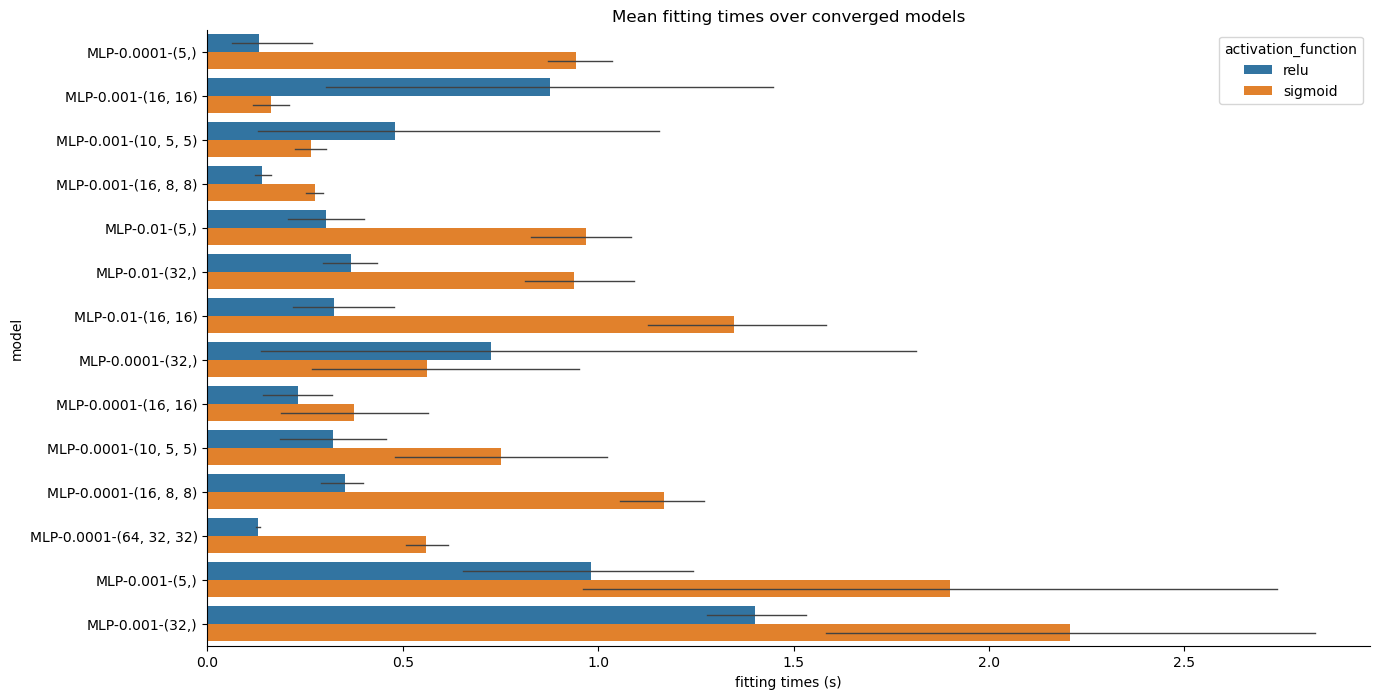

In [349]:
_, ax = plt.subplots(figsize=(15, 8))
sns.despine()
sns.barplot(data=df_fit_times[df_fit_times.num_models_converged == 2], y='model_short', x='metric_value', hue='activation_function', ax=ax, errwidth=1)
ax.set(title='Mean fitting times over converged models', xlabel='fitting times (s)', ylabel='model')

[Text(0.5, 1.0, 'Mean fitting times for best model in each architecture'),
 Text(0.5, 0, 'fitting times (s)'),
 Text(0, 0.5, 'layer size')]

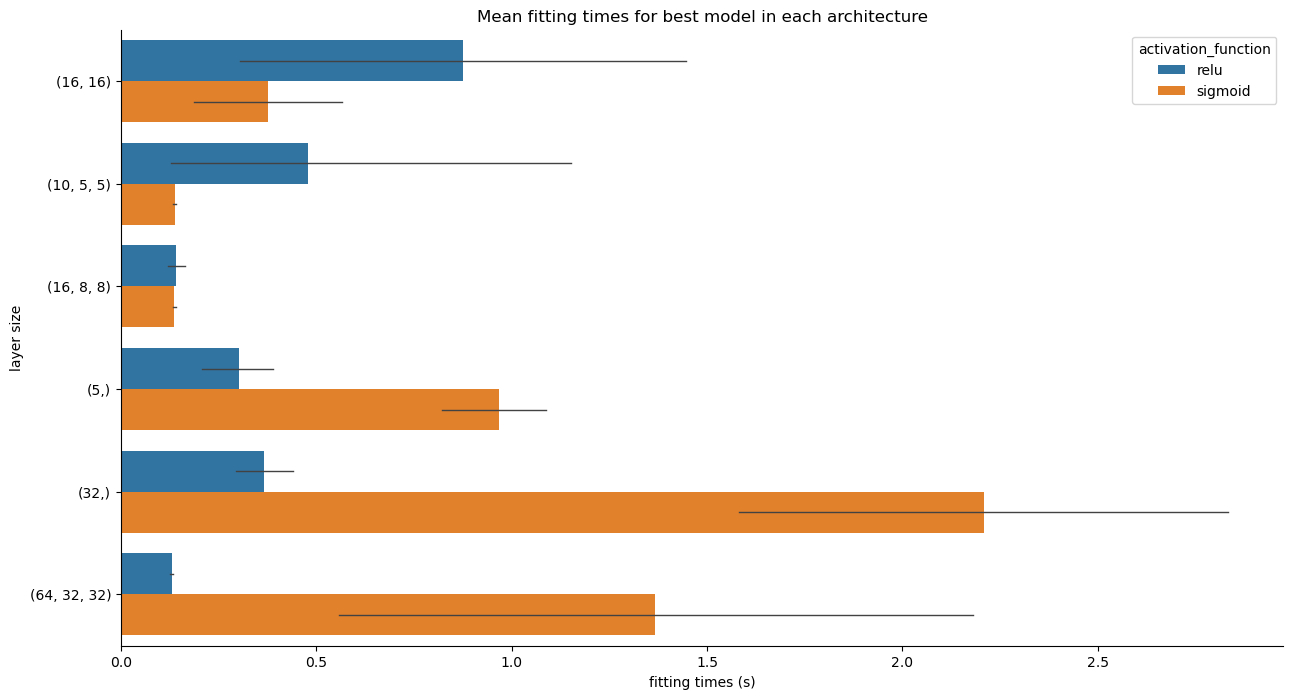

In [350]:
_, ax = plt.subplots(figsize=(15, 8))
sns.despine()
ax = sns.barplot(data=df_fit_times[df_fit_times.model.isin(max_accuracies_models.model.values)], y='hidden_layer_sizes', x='metric_value', hue='activation_function', ax=ax, errwidth=1)
ax.set(title=f'Mean fitting times for best model in each architecture', xlabel='fitting times (s)', ylabel='layer size')

#### Performance

In [351]:
df_test_scores = get_specific_table(model_lists_melted_df, col='test_score')

[Text(0.5, 1.0, 'Mean f1 scores over converged models'),
 Text(0.5, 0, 'f1 score'),
 Text(0, 0.5, 'model')]

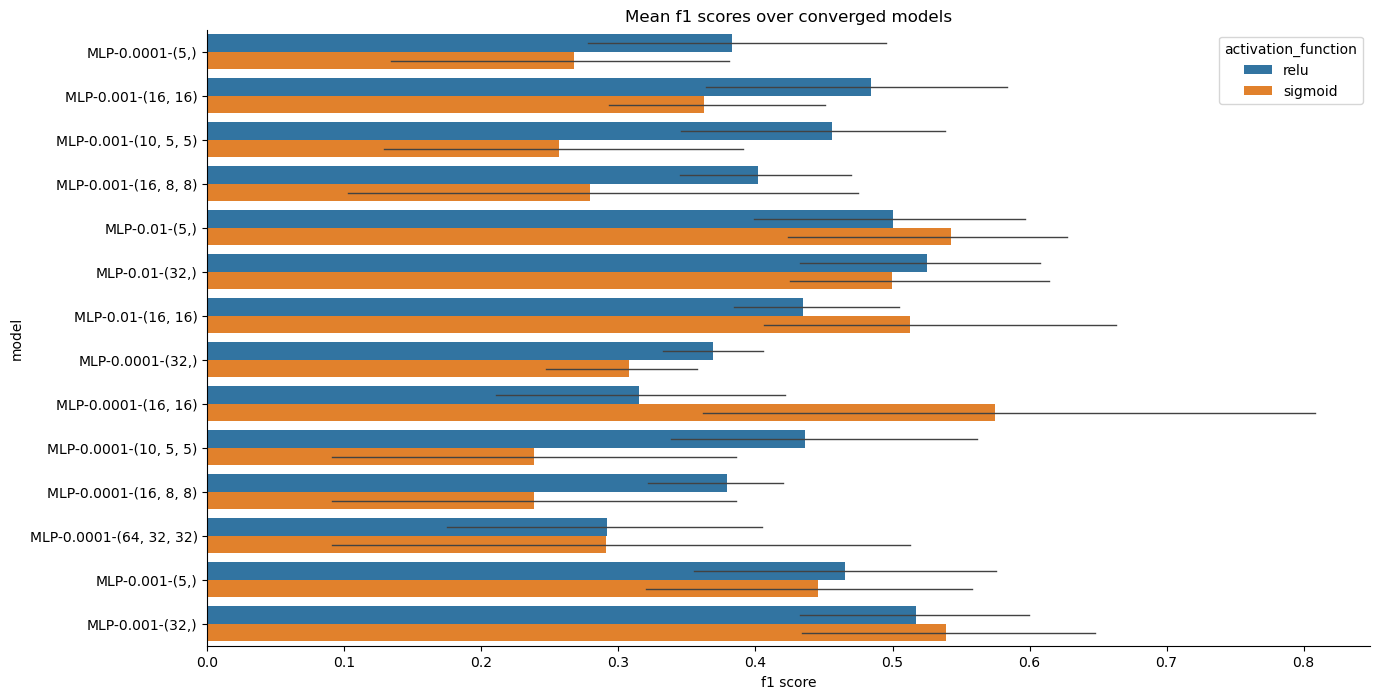

In [352]:
_, ax = plt.subplots(figsize=(15, 8))
sns.despine()
sns.barplot(data=df_test_scores[df_test_scores.num_models_converged == 2], y='model_short', x='metric_value', hue='activation_function', ax=ax, errwidth=1)
ax.set(title='Mean f1 scores over converged models', xlabel='f1 score', ylabel='model')

[Text(0.5, 1.0, 'Mean f1 scores for best model in each architecture'),
 Text(0.5, 0, 'f1 scores'),
 Text(0, 0.5, 'layer size')]

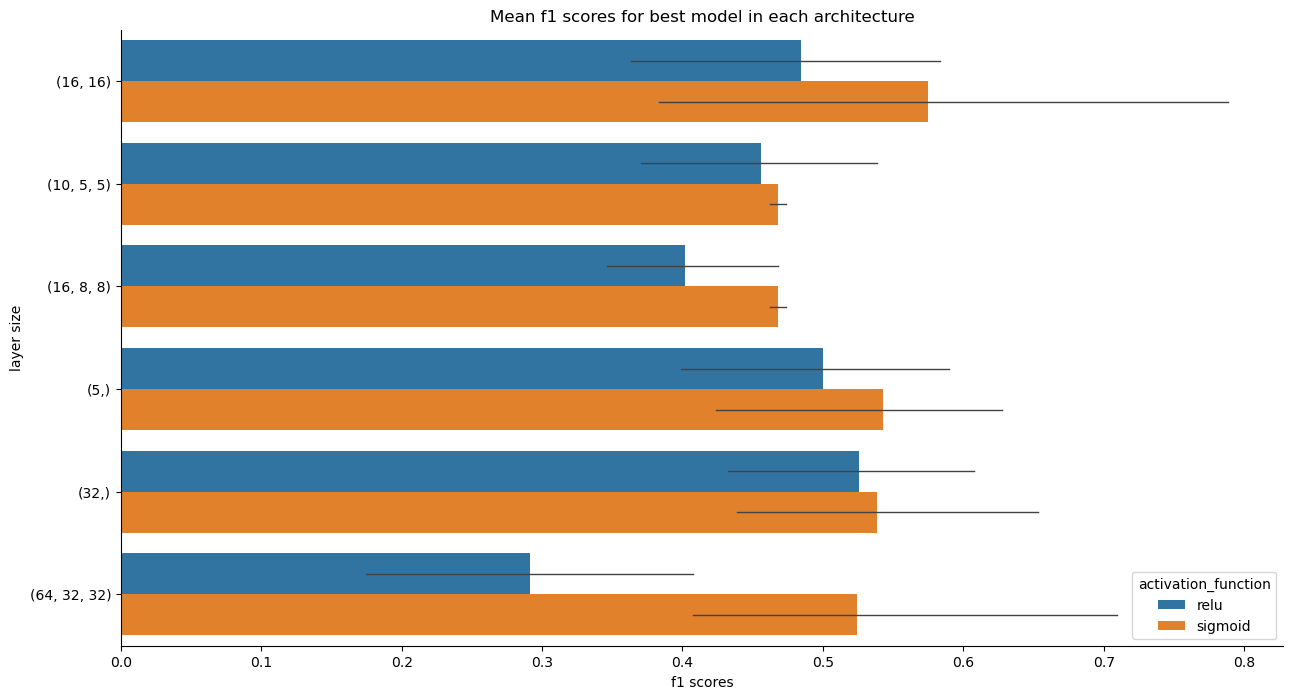

In [353]:
_, ax = plt.subplots(figsize=(15, 8))
sns.despine()
ax = sns.barplot(data=df_test_scores[df_test_scores.model.isin(max_accuracies_models.model.values)], y='hidden_layer_sizes', x='metric_value', hue='activation_function', ax=ax, errwidth=1)
ax.set(title=f'Mean f1 scores for best model in each architecture', xlabel='f1 scores', ylabel='layer size')

#### Convergence and vanishing gradients

3 plots:
- relu vs sigmoid where both converged - Done
- best accuracy models for relu and for sigmoid; plot fitting times - Done
- convergence + vanishing gradients depending on learning rate, group by lr, agg total for lr

In [16]:
vg_f1_threshold = 0.3
model_lists_df['vanishing_gradient'] = 0    
for i in range(5):
    vanishing_grad_df = model_lists_df.loc[(model_lists_df[f'converged_cv{i}']) & (model_lists_df[f'test_score_cv{i}'] < vg_f1_threshold), 'vanishing_gradient']
    vanishing_grad_df = vanishing_grad_df + 1

In [432]:
i=0
model_lists_df[(model_lists_df[f'converged_cv{i}']) & (model_lists_df[f'test_score_cv{i}'] < vg_f1_threshold)][f'training_losses_cv{i}'].apply(lambda x: (x[0], x[-1]))

2      (0.7223105455817824, 0.6762902434006007)
5       (0.6965500329154961, 0.695996766485364)
6     (0.6939785455644978, 0.23173164461545884)
11     (0.7922993844505838, 3.1970726296953873)
30      (0.942095681590011, 0.7177135040604655)
33     (0.8092948432367146, 0.7089088343045475)
34     (0.9131571404224041, 0.7045222407519428)
35      (0.800228647537754, 0.6954203902471287)
38     (0.7468904715189434, 0.6678497908403743)
39      (0.7872006183946472, 0.694899351965935)
40     (0.8676678973013348, 0.6910510157986991)
Name: training_losses_cv0, dtype: object

In [35]:
model_lists_df[model_lists_df.model == 'MLP-sigmoid-0.0001-(16, 16)']['test_score'].values

array([array([0.41176471, 0.65714286, 1.        , 0.28571429, 0.52      ])],
      dtype=object)

In [30]:
i=0
gradients = model_lists_df.loc[49, 'gradients'][0]

In [28]:
model_lists_df.loc[49, ['model', 'test_score_cv0']]

model             MLP-sigmoid-0.1-(32,)
test_score_cv0                 0.435737
Name: 49, dtype: object

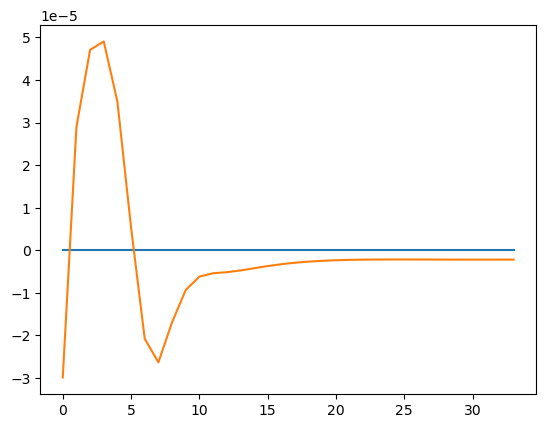

In [26]:
for i, grad in gradients.items():
    sns.lineplot(x=range(len(grad)), y=grad)

In [447]:
model_lists_df.loc[49, f'test_score_cv{i}']

0.43573667711598746

<Axes: >

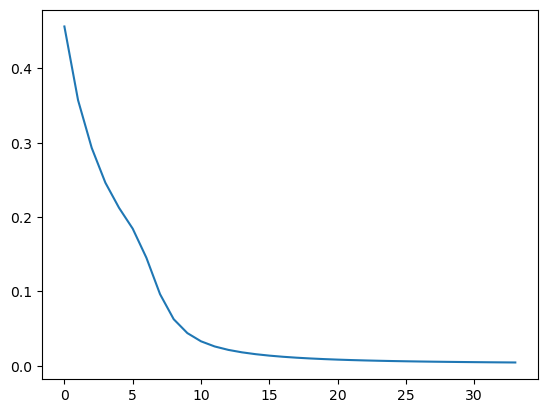

In [446]:
sns.lineplot(x=range(len(model_lists_df.loc[49, f'validation_losses_cv{i}'])), y=model_lists_df.loc[49, f'validation_losses_cv{i}'])

In [426]:
model_lists_df.groupby(['learning_rate', 'activation_function'])['not_converged_num', 'vanishing_gradient'].sum()

not_converged_num  vanishing_gradient
learning_rate activation_function                                       
0.0001        relu                                 0                   0
              sigmoid                              0                   0
0.0010        relu                                 2                   0
              sigmoid                              0                   0
0.0100        relu                                10                   0
              sigmoid                              0                   0
0.1000        relu                                29                   0
              sigmoid                              0                   0
0.5000        relu                                30                   0
              sigmoid                              0                   0

## Comparison 